In [2]:
import pandas as pd
import json
from collections import Counter
from sklearn.preprocessing import MultiLabelBinarizer
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create DataFrame

In [5]:
df_cred = pd.read_csv('/Users/greysonmeyer/Downloads/tmdb5000/tmdb_5000_credits.csv')[['movie_id', 'cast', 'crew']]
df_mov = pd.read_csv('/Users/greysonmeyer/Downloads/tmdb5000/tmdb_5000_movies.csv').drop(columns=['homepage', 'keywords', 'original_language', 'original_title', 'overview', 'production_countries', 'spoken_languages', 'status', 'tagline', 'vote_average', 'vote_count'])
df = df_cred.merge(df_mov, left_on='movie_id', right_on='id')
df = df.drop(columns='id')

# Feature Engineering

## Genres Column

How many unique genres are in df?

In [6]:
df['genres_parsed'] = df['genres'].apply(json.loads)
all_genres = [genre['name'] for sublist in df['genres_parsed'] for genre in sublist]
unique_genres = set(all_genres)
print(f"Number of unique genres: {len(unique_genres)}")

Number of unique genres: 20


There are some pretty rare genres in here. In order to not make the data too sparse, I will only consider the top 10 most common genres, and then combine the other genres into "Other". Now we can one-hot encode this column

In [7]:
genre_counts = Counter([g for lst in df['genres_parsed'] for g in [d['name'] for d in lst]])
df['genre_names'] = df['genres_parsed'].apply(lambda lst: [d['name'] for d in lst])
top_genres = [g for g, count in genre_counts.most_common(10)]

df['genre_filtered'] = df['genre_names'].apply(
    lambda genres: [g if g in top_genres else 'Other' for g in genres]
)

# One-hot encode using MultiLabelBinarizer
mlb = MultiLabelBinarizer()
genre_encoded = pd.DataFrame(
    mlb.fit_transform(df['genre_filtered']),
    columns=[f"genre_{g}" for g in mlb.classes_],
    index=df.index
)

df = pd.concat([df, genre_encoded], axis=1)
df = df.drop(columns=['genres', 'genres_parsed', 'genre_names', 'genre_filtered'])

## Release Date

In [8]:
df['release_date'] = pd.to_datetime(df['release_date'])
def assign_season_bucket(month):
    if month in [5, 6, 7, 8]:
        return 'summer_blockbuster'
    elif month in [9, 10, 11, 12]:
        return 'award_season'
    else:
        return 'winter_low_season'

df['release_month'] = df['release_date'].dt.month
df['season_bucket'] = df['release_month'].apply(assign_season_bucket)
season_dummies = pd.get_dummies(df['season_bucket'])
df = pd.concat([df, season_dummies], axis=1)
df = df.drop(columns=['release_month', 'season_bucket'])

## Sequel

We create a column that encodes whether the film is a sequel or not.

In [9]:
def is_likely_sequel(title):
    title = title.lower().strip()
    return bool(re.search(r'\s[1-9]$', title))

df['likely_sequel'] = df['title'].apply(is_likely_sequel)
print(df[df['likely_sequel'] == True]['title'])

5                    Spider-Man 3
18                 Men in Black 3
30                   Spider-Man 2
31                     Iron Man 3
38       The Amazing Spider-Man 2
                  ...            
4234                    Session 9
4276                    Def-Con 4
4282       Friday the 13th Part 2
4342             God's Not Dead 2
4435    The Horror Network Vol. 1
Name: title, Length: 110, dtype: object


## Previous Films By Director

In [10]:
def extract_director(crew_json_str):
    try:
        crew = json.loads(crew_json_str)
        for person in crew:
            if person.get('job') == 'Director':
                return person.get('name')
    except (TypeError, json.JSONDecodeError):
        return None

df['director'] = df['crew'].apply(extract_director)
df = df.drop(columns='crew')
df = df.dropna(subset=['director'])

In [11]:
df = df.sort_values(by=['director', 'release_date'])
df['num_prev_films_by_director'] = df.groupby('director').cumcount()
print(df['num_prev_films_by_director'].value_counts())

num_prev_films_by_director
0     2349
1      874
2      509
3      339
4      211
5      139
6       97
7       65
8       42
9       34
10      28
11      20
12      15
13      11
14       9
15       7
16       4
17       4
18       4
19       4
20       2
21       1
22       1
23       1
24       1
25       1
26       1
Name: count, dtype: int64


## Distributor

How many distinct production companies are present in the dataset?

In [12]:
df['productions_parsed'] = df['production_companies'].apply(json.loads)
all_companies = [company['name'] for sublist in df['productions_parsed'] for company in sublist]
unique_companies = set(all_companies)
print(f"Number of unique production companies: {len(unique_companies)}")

Number of unique production companies: 5012


Over 5000 production companies is way too many to one-hot encode, so I will do the same thing as with the genres and only consider the top 10 as being distinct, and lump the rest together as "Other." I may change 10 to a higher number in the future if sparseness becomes less of an issue and production companies appear to directly affect the model's predictive csapabilities.

In [13]:
company_counts = Counter([c for lst in df['productions_parsed'] for c in [d['name'] for d in lst]])
df['companies_parsed'] = df['production_companies'].apply(json.loads)
df['company_names'] = df['companies_parsed'].apply(lambda lst: [d['name'] for d in lst])
top_companies = [g for g, count in company_counts.most_common(10)]

df['company_filtered'] = df['company_names'].apply(
    lambda companies: [g if g in top_companies else 'Other' for g in companies]
)

mlb = MultiLabelBinarizer()
production_encoded = pd.DataFrame(
    mlb.fit_transform(df['company_filtered']),
    columns=[f"production_company_{c}" for c in mlb.classes_],
    index=df.index
)

df = pd.concat([df, production_encoded], axis=1)
df = df.drop(columns=['production_companies', 'companies_parsed', 'company_names', 'company_filtered', 'productions_parsed'])

## Director & Cast

The goal here is to isolate the director of each film and the three main cast members of each movie. Now, it would be ridiculous to try and one-hot encode these values, so instead I endeavor to assign each director and cast member a "popularity score" based on how often the director/cast member appears in the dataset and the average revenue of the movies that they have taken part in. First I will isolate the three lead actors for each film.

In [14]:
def get_top_3_cast(cast_json):
    try:
        cast_list = json.loads(cast_json)
        sorted_cast = sorted(cast_list, key=lambda x: x.get('order', float('inf')))
        top_3 = [member['name'] for member in sorted_cast[:3]]
        return top_3
    except:
        return []
df['top_3_cast'] = df['cast'].apply(get_top_3_cast)
df['lead_actor'] = df['top_3_cast'].apply(lambda x: x[0] if len(x) > 0 else None)
df['second_actor'] = df['top_3_cast'].apply(lambda x: x[1] if len(x) > 1 else None)
df['third_actor'] = df['top_3_cast'].apply(lambda x: x[2] if len(x) > 2 else None)
df = df.drop(columns=['cast', 'top_3_cast'])
df = df.dropna(subset = 'runtime')
df = df[df['revenue'] > 0]

For each director and actor I want to calculate the average revenue generated by them. I have to be careful of data leakage when performing train_test_splitsd and kfold cross validation, so I will be creating a function that can be called to compute the values with respect to the training dataframe whenever needed.

In [15]:
print(df[df['revenue'] == df['revenue'].min()]['title'])

3372    Split Second
Name: title, dtype: object


In [16]:
def get_scores(df_tt, df_test):
    df_train = df_tt.copy()
    df_test_scored = df_test.copy()

    global_avg = df_train['revenue'].mean()


    director_stats = df_train.groupby('director')['revenue'].agg(
        director_avg_revenue='mean').reset_index()

    # Merge into both train and test
    df_train = df_train.merge(director_stats, how='left', on='director')
    df_train['director_avg_revenue'] = df_train['director_avg_revenue'].fillna(global_avg)

    df_test_scored = df_test_scored.merge(director_stats, how='left', on='director')
    df_test_scored['director_avg_revenue'] = df_test_scored['director_avg_revenue'].fillna(global_avg)

    melted = df_train.melt(
        id_vars='revenue',
        value_vars=['lead_actor', 'second_actor', 'third_actor'],
        value_name='actor'
    ).dropna(subset=['actor'])

    actor_stats = melted.groupby('actor')['revenue'].agg(
        actor_avg_revenue='mean',
        actor_count='count'
    ).reset_index()

    for role in ['lead_actor', 'second_actor', 'third_actor']:
        df_train = df_train.merge(actor_stats, how='left', left_on=role, right_on='actor')
        df_train = df_train.rename(columns={
            'actor_avg_revenue': f'{role}_avg_revenue',
            'actor_count': f'{role}_count'
        })
        df_train = df_train.drop(columns='actor')
        df_train[f'{role}_avg_revenue'] = df_train[f'{role}_avg_revenue'].fillna(global_avg)
        df_train[f'{role}_count'] = df_train[f'{role}_count'].fillna(1)

        df_test_scored = df_test_scored.merge(actor_stats, how='left', left_on=role, right_on='actor')
        df_test_scored = df_test_scored.rename(columns={
            'actor_avg_revenue': f'{role}_avg_revenue',
            'actor_count': f'{role}_count'
        })
        df_test_scored = df_test_scored.drop(columns='actor')
        df_test_scored[f'{role}_avg_revenue'] = df_test_scored[f'{role}_avg_revenue'].fillna(global_avg)
        df_test_scored[f'{role}_count'] = df_test_scored[f'{role}_count'].fillna(1)
    
    for col in ['director_avg_revenue', 'lead_actor_avg_revenue', 'second_actor_avg_revenue', 'third_actor_avg_revenue']:
        df_test_scored[col + '_log'] = np.log1p(df_test_scored[col])
        df_train[col + '_log'] = np.log1p(df_train[col])

    return df_train, df_test_scored

Let's look at the distributions of these new computed values to see if any transformations need to occur.

In [17]:
def plot_score_distributions(df, columns):
    num_cols = len(columns)
    fig, axes = plt.subplots(num_cols, 2, figsize=(12, 4 * num_cols))

    for i, col in enumerate(columns):
        sns.histplot(df[col], ax=axes[i, 0], bins=50, kde=True)
        axes[i, 0].set_title(f'Histogram of {col}')
        
        sns.boxplot(x=df[col], ax=axes[i, 1])
        axes[i, 1].set_title(f'Boxplot of {col}')

    plt.tight_layout()
    plt.show()

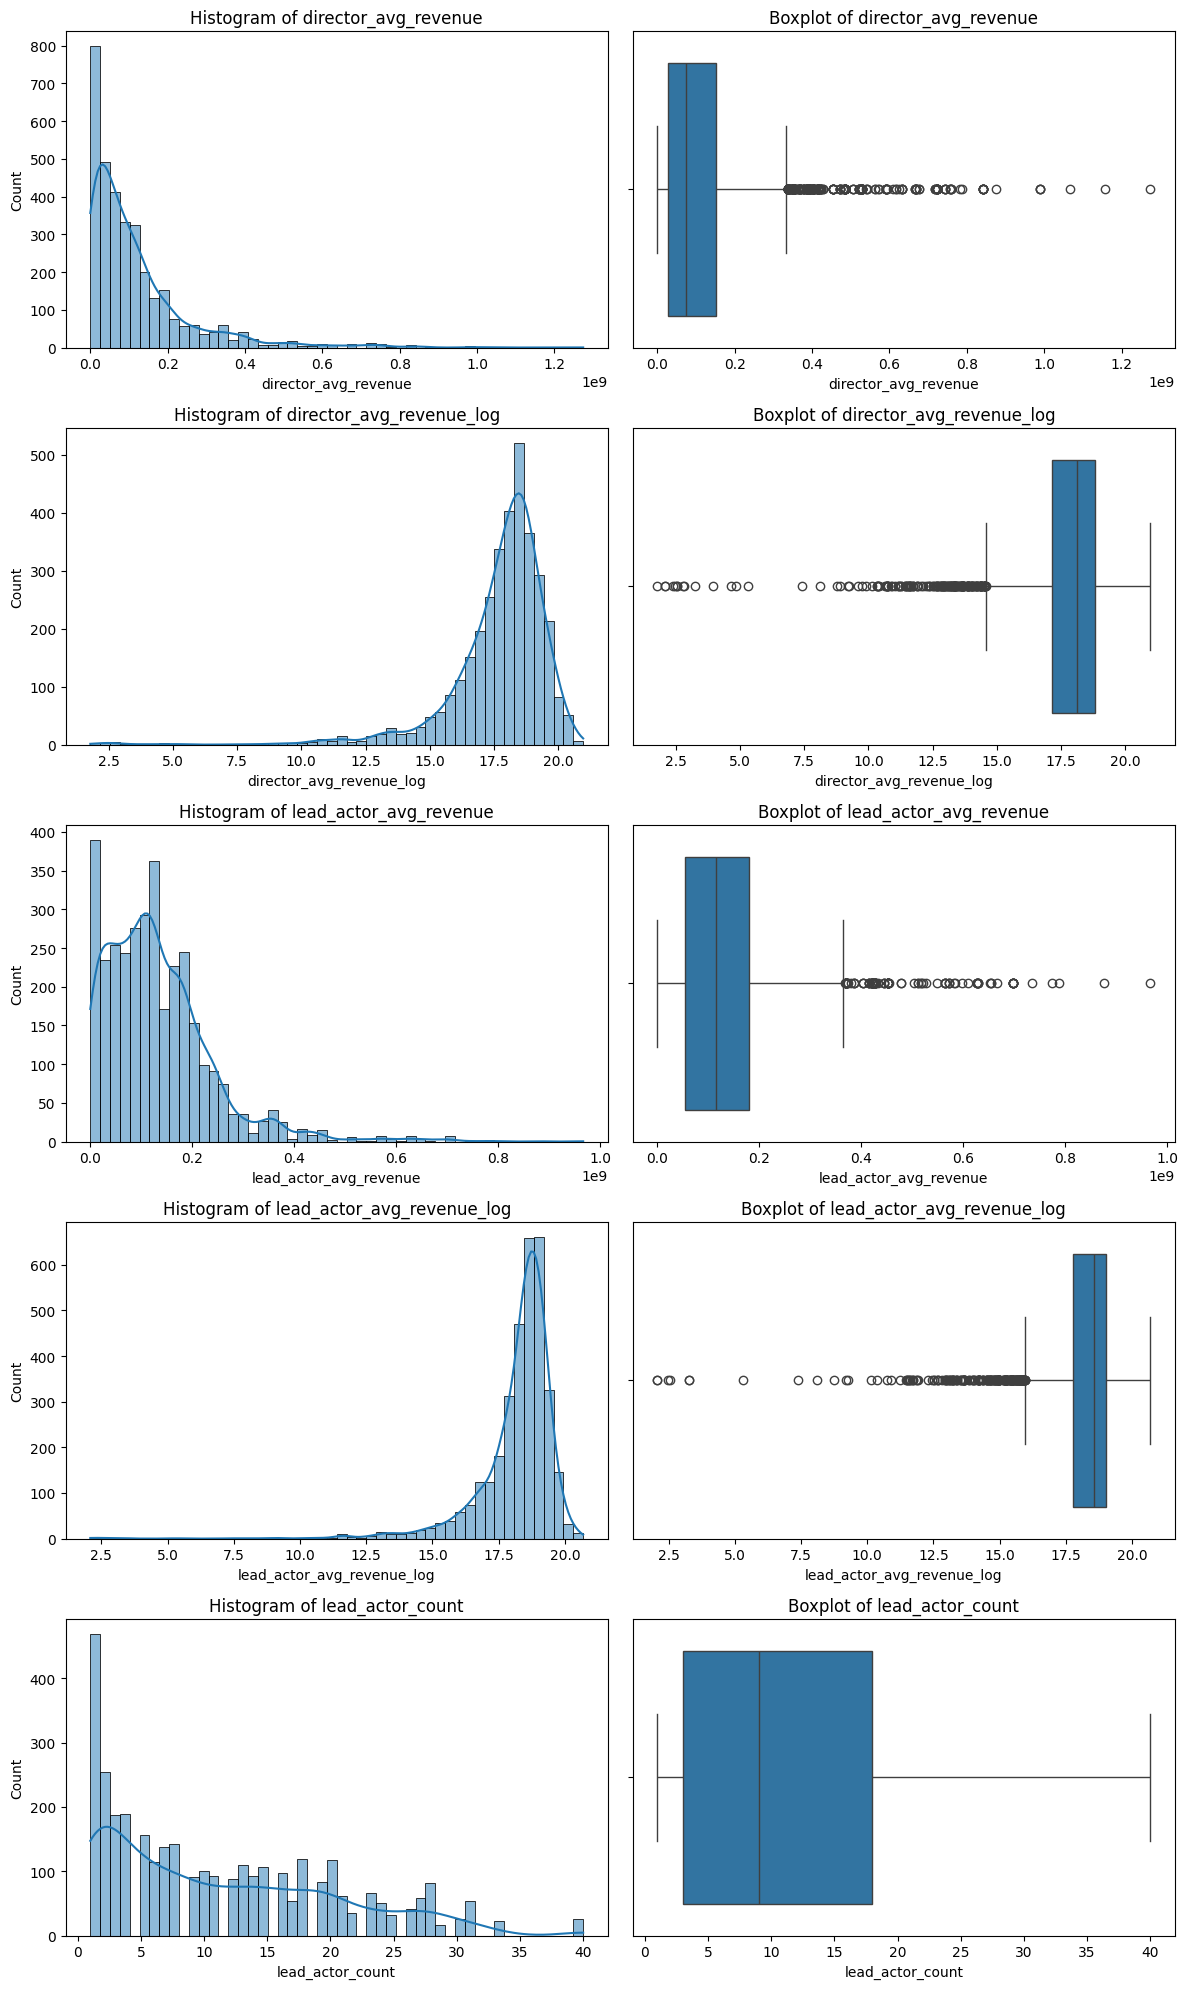

In [ ]:
score_columns = [
    'director_avg_revenue',
    'director_avg_revenue_log',
    'lead_actor_avg_revenue',
    'lead_actor_avg_revenue_log',
    'lead_actor_count'
]

df_scored, df2 = get_scores(df, df)
# df.to_csv("/Users/greysonmeyer/Downloads/cleaned_film_data.csv", index=False)
plot_score_distributions(df_scored, score_columns)

The revenue graphs are left-skewed so I have decided to include a log-transformed version of the revenue columns in the dataframe to see if the transformed values perform better in the context of the eventual model.